In [120]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import pi
from scipy.optimize import fmin_l_bfgs_b
from numpy.fft import *
%matplotlib notebook

# Input parametrs

In [121]:
N=10000;Nc=4;Nf=4;Nb=4;L=int(np.sqrt(Nc));Nq=10000
beta=1;
mu=0;
t=1;U=1;V=1;V0=4*V
n=100
matsubara=(2*np.linspace(0,n,n+1)+1)*np.pi/beta
boson_matsubara=(2*np.linspace(0,n,n+1))*np.pi/beta

# Fermion k-space

In [122]:
kx=np.linspace(-2*pi,2*pi,2*int(np.sqrt(N))+1);kx=np.delete(kx,0);min_k=np.min(kx);max_k=np.max(kx)
ky=np.linspace(-2*pi,2*pi,2*int(np.sqrt(N))+1);ky=np.delete(ky,0)
kx,ky=np.meshgrid(kx,ky)
E_k=-2*t*(np.cos(kx)+np.cos(ky))

<IPython.core.display.Javascript object>


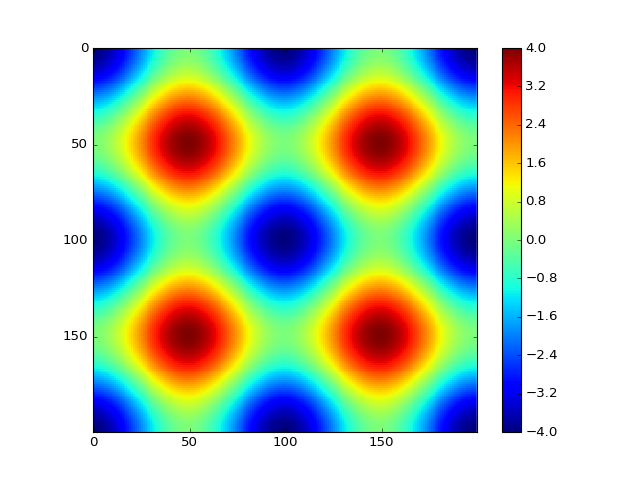

In [123]:
plt.figure()
plt.imshow(E_k,interpolation='None')
plt.colorbar()

# Boson q-space

In [124]:
qx=np.linspace(-2*pi,2*pi,2*int(np.sqrt(Nq))+1);qx=np.delete(qx,0);min_q=np.min(qx);max_q=np.max(qx)
qy=np.linspace(-2*pi,2*pi,2*int(np.sqrt(Nq))+1);qy=np.delete(qy,0)
qx,qy=np.meshgrid(qx,qy)
V_q=4*V-2*V*(np.cos(qx)+np.cos(qy))

<IPython.core.display.Javascript object>


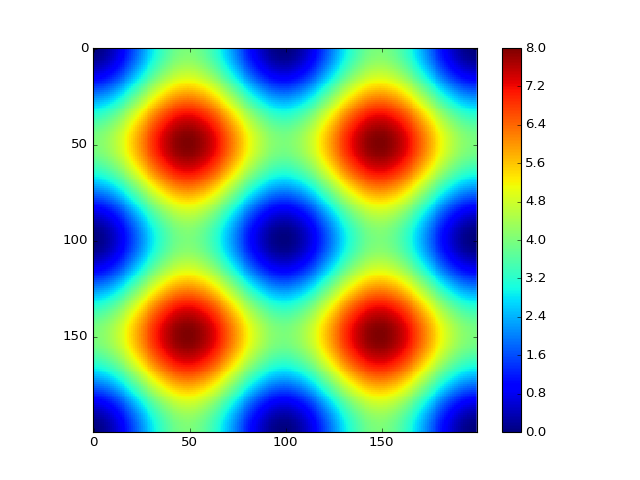

In [125]:
plt.figure()
plt.imshow(V_q,interpolation='None')
plt.colorbar()

# Cluster K-space

In [63]:
KX=np.linspace(-pi,pi,L+1);KX=np.delete(KX,0);dK=KX[1]-KX[0];min_K=np.min(KX);max_K=np.max(KX)
KY=np.linspace(-pi,pi,L+1);KY=np.delete(KY,0)
KX,KY=np.meshgrid(KX,KY)

# Patching

In [126]:
G0_K=np.empty((matsubara.size,KX.shape[0],KX.shape[1]),dtype=np.complex128)
E_K=np.empty((KX.shape[0],KX.shape[1]))

P0_K=np.empty((matsubara.size,KX.shape[0],KX.shape[1]),dtype=np.complex128)
V_K=np.empty((KX.shape[0],KX.shape[1]))

for i in xrange(L):
    for j in xrange(L):  
            indexes_k=((kx>(KX[i,j]-dK/2.))&(kx<(KX[i,j]+dK/2.)))&((ky>(KY[i,j]-dK/2.))&(ky<(KY[i,j]+dK/2.)))
            indexes_q=((qx>(KX[i,j]-dK/2.))&(qx<(KX[i,j]+dK/2.)))&((qy>(KY[i,j]-dK/2.))&(qy<(KY[i,j]+dK/2.)))
            for k in xrange(matsubara.size):
                G0_K[k,i,j]=Nc*np.sum((1j*matsubara[k]+mu-E_k[indexes_k])**(-1))/N
            P0_K[:,i,j]=Nc*np.sum(V_q[indexes_q])/Nq
            E_K[i,j]=Nc*np.sum(E_k[indexes_k])/N
            V_K[i,j]=Nc*np.sum(V_q[indexes_q])/Nq

In [127]:
np.round(P0_K[0,:,:].real,2)

array([[ 1.35,  3.89],
       [ 3.89,  6.55]])

<IPython.core.display.Javascript object>


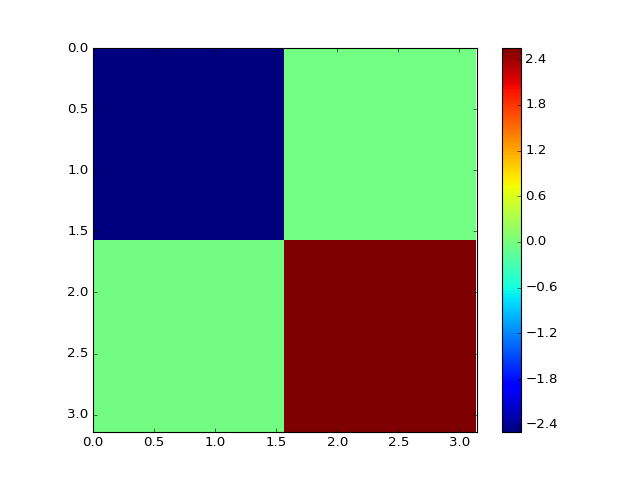

In [128]:
plt.figure()
plt.imshow(E_K,interpolation='None', extent=(min_K,max_K, max_K, min_K))
plt.colorbar()

<IPython.core.display.Javascript object>


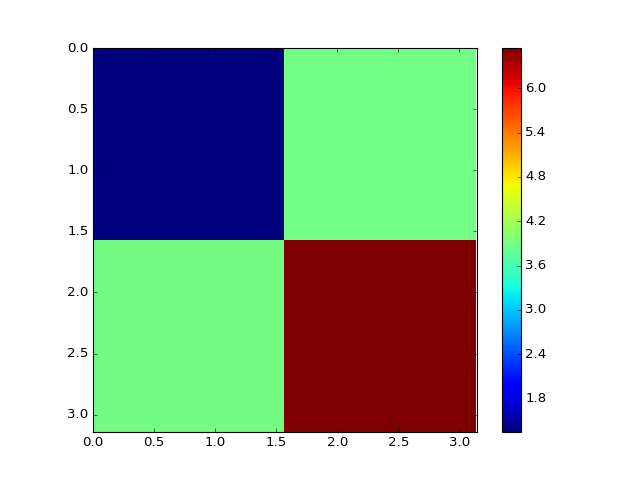

In [98]:
plt.figure()
plt.imshow(V_K,interpolation='None', extent=(min_K,max_K, max_K, min_K))
plt.colorbar()

# Transform matrix

In [129]:
T=np.array([[1,1,1,1],[1,-1,-1,1],[1,-1,1,-1],[1,1,-1,-1]])/2.

In [130]:
T

array([[ 0.5,  0.5,  0.5,  0.5],
       [ 0.5, -0.5, -0.5,  0.5],
       [ 0.5, -0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5, -0.5]])

# Find Hamiltonian parametrs

In [131]:
from numpy.linalg import inv

In [132]:
from scipy.optimize import fmin_l_bfgs_b

# Fitting fermions

In [133]:
G0_R=np.zeros_like(G0_K);
for i in xrange(matsubara.size):
    G0_R[i,:,:]=ifft2(ifftshift(G0_K[i,:,:]))
G0_IJ=np.zeros((matsubara.size,Nc,Nc),dtype=np.complex128)
for i in xrange(Nc):
    for j in xrange(Nc):
        x=i%L-j%L;y=i//L-j//L
        if x<0: x=x+L
        if y<0: y=y+L
        G0_IJ[:,i,j]=G0_R[:,x,y]

In [134]:
G0_M=np.zeros_like(G0_IJ)
for i in xrange(matsubara.size):
    G0_M[i,:,:]=(inv(T).dot(G0_IJ[i,:,:])).dot(T)

In [135]:
def molecular_GF(parameters):
    em=parameters[0];h=parameters[1:Nf/Nc+1];ek=parameters[Nf/Nc+1:]
    G0=np.zeros(matsubara.size,dtype=np.complex128)
    for i in xrange(matsubara.size):
        G0[i]=(1j*matsubara[i]+mu-em-np.sum(h**2/(1j*matsubara[i]-ek)))**(-1)
    return G0

In [136]:
bounds=[]
bounds.append((-4*t,4*t))
for i in xrange(Nf/Nc):bounds.append((0.05*t,4*t))
for i in xrange(Nf/Nc):bounds.append((-4*t,4*t))

parameters=[]
for i in xrange(Nc):
    p_fermion=2*np.random.random(1+2*Nf/Nc)-1;
    G0_real=G0_M[:,i,i]
    
    def error_G0(parameters):
        G0=molecular_GF(parameters)
        return np.sum(np.abs(np.conj(G0-G0_real)*(G0-G0_real))/matsubara)
 
    p_fermion=fmin_l_bfgs_b(error_G0, x0=p_fermion,approx_grad=True,disp=True,bounds=bounds)
    parameters.append(p_fermion[0])

In [137]:
em=np.zeros((Nc,Nc));h=np.zeros((Nc,Nf));ek=np.zeros(Nf);
for i in xrange(Nc):
    em[i,i]=parameters[i][0]
    h [i,i*Nf/Nc:(i*Nf/Nc+Nf/Nc)]=parameters[i][1:Nf/Nc+1]
    ek[i*Nf/Nc:(i*Nf/Nc+Nf/Nc)]=parameters[i][Nf/Nc+1:]

# Fitting bosons

In [138]:
P0_R=np.zeros_like(P0_K);
for i in xrange(matsubara.size):
    P0_R[i,:,:]=ifft2(ifftshift(P0_K[i,:,:]))
    
P0_IJ=np.zeros((matsubara.size,Nc,Nc),dtype=np.complex128)
for i in xrange(Nc):
    for j in xrange(Nc):
            x=i%L-j%L;y=i//L-j//L
            if x<0: x=x+L
            if y<0: y=y+L
            P0_IJ[:,i,j]=P0_R[:,x,y]

P0_M=np.zeros_like(P0_IJ)
for i in xrange(matsubara.size):
    P0_M[i,:,:]=(inv(T).dot(P0_IJ[i,:,:])).dot(T)

In [139]:
def molecular_PF(parameters):
    em=parameters[0];y=parameters[1:Nb/Nc+1];eq=parameters[Nb/Nc+1:]
    P0=np.zeros(matsubara.size,dtype=np.complex128)
    eq[eq==0]=10**(-8)
    for i in xrange(matsubara.size):
        P0[i]=(em+np.sum(y**2*eq/(boson_matsubara[i]**2+eq**2)))
    return P0

In [140]:
bounds=[]
bounds.append((-1000*V,1000*V))
for i in xrange(Nb/Nc):bounds.append((0,V))
for i in xrange(Nb/Nc):bounds.append((0,8*V))

boson_parameters=[]
for i in xrange(Nc):
    p_boson=2*np.random.random(1+2*Nb/Nc);
    P0_real=P0_M[:,i,i]
    
    def error_P0(parameters):
        P0=molecular_PF(parameters)
        return np.sum((P0.real-P0_real.real)**2)
 
    p_boson=fmin_l_bfgs_b(error_P0, x0=p_boson,approx_grad=True,disp=True,bounds=bounds)
    boson_parameters.append(p_boson[0])

In [141]:
en=np.zeros((Nc,Nc));y=np.zeros((Nc,Nb));eq=np.zeros(Nb);
for i in xrange(Nc):
    en[i,i]=boson_parameters[i][0]
    y [i,i*Nb/Nc:(i*Nb/Nc+Nb/Nc)]=boson_parameters[i][1:Nb/Nc+1]
    eq[i*Nb/Nc:(i*Nb/Nc+Nb/Nc)]=boson_parameters[i][Nb/Nc+1:]

In [142]:
en

array([[ 6.54564279,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.34687134,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  3.89454338,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  3.89454335]])

# Fermion parameters

In [143]:
np.round((inv(T).dot(em)).dot(T),2)

array([[-0.08,  1.25,  1.26, -0.01],
       [ 1.25, -0.08, -0.01,  1.26],
       [ 1.26, -0.01, -0.08,  1.25],
       [-0.01,  1.26,  1.25, -0.08]])

In [144]:
np.round(ek,2)

array([-0.47,  0.  , -0.37, -0.49])

In [145]:
np.round(T.dot(np.abs(h)),2)

array([[ 0.36,  0.47,  0.47,  0.48],
       [ 0.36, -0.47, -0.47,  0.48],
       [ 0.36, -0.47,  0.47, -0.48],
       [ 0.36,  0.47, -0.47, -0.48]])

# Boson parameters

In [146]:
np.round(eq,2)

array([ 0.53,  0.94,  2.06,  2.02])

In [147]:
np.round((inv(T).dot(en)).dot(T),2)

array([[ 3.92,  1.3 ,  1.3 ,  0.03],
       [ 1.3 ,  3.92,  0.03,  1.3 ],
       [ 1.3 ,  0.03,  3.92,  1.3 ],
       [ 0.03,  1.3 ,  1.3 ,  3.92]])

In [148]:
np.round(T.dot(np.abs(y)),2)

array([[ 0.,  0.,  0.,  0.],
       [ 0., -0., -0.,  0.],
       [ 0., -0.,  0., -0.],
       [ 0.,  0., -0., -0.]])

# Plots

# Boson

<IPython.core.display.Javascript object>


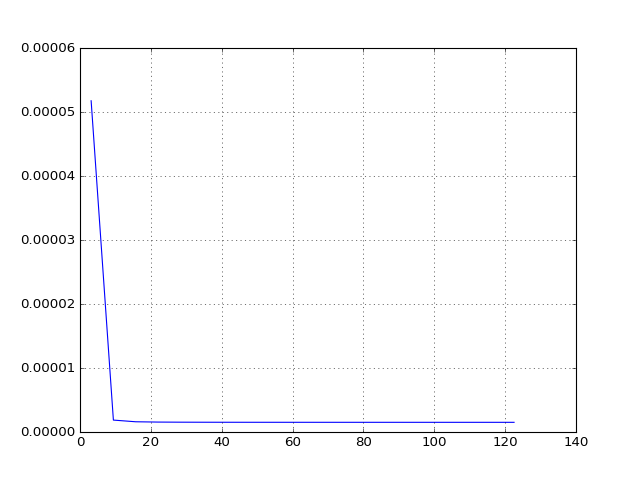

<IPython.core.display.Javascript object>


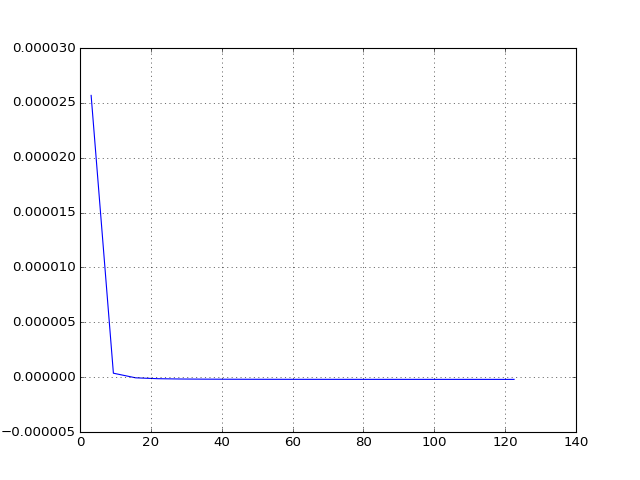

<IPython.core.display.Javascript object>


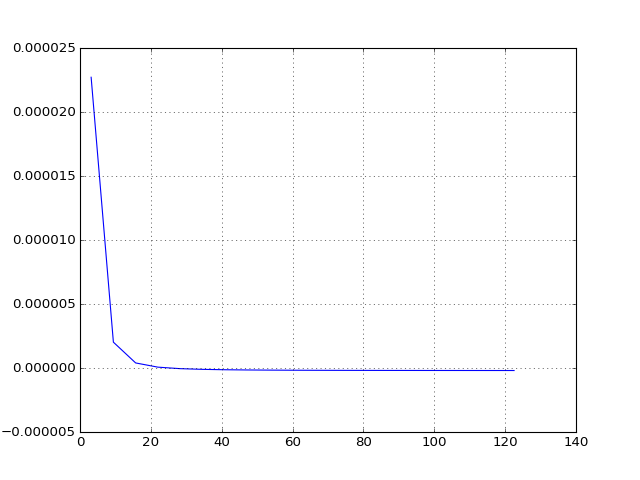

<IPython.core.display.Javascript object>


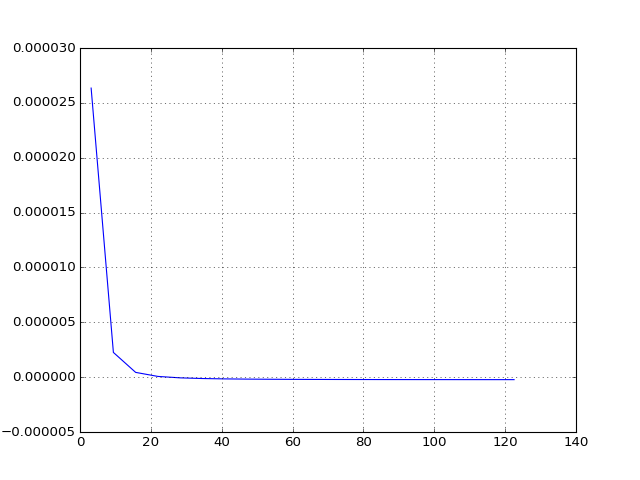

In [149]:
for i in xrange(Nc):
    f, (ax1) = plt.subplots(1, 1, sharey=True)  
    ax1.plot(matsubara[:20],molecular_PF(boson_parameters[i])[:20].real-P0_M[:,i,i][:20].real)
    ax1.grid()

# Fermion

<IPython.core.display.Javascript object>


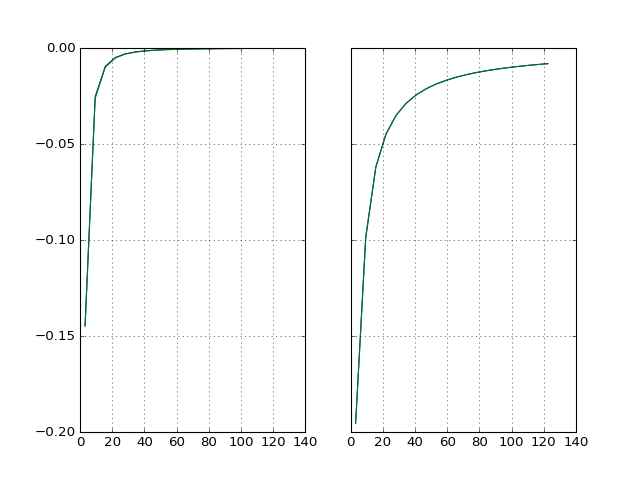

<IPython.core.display.Javascript object>


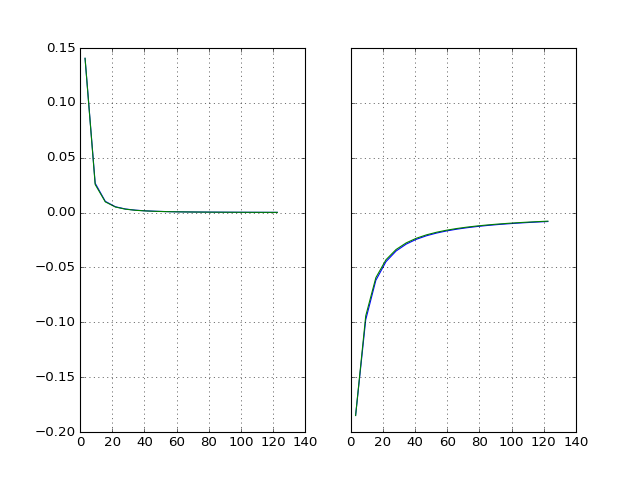

<IPython.core.display.Javascript object>


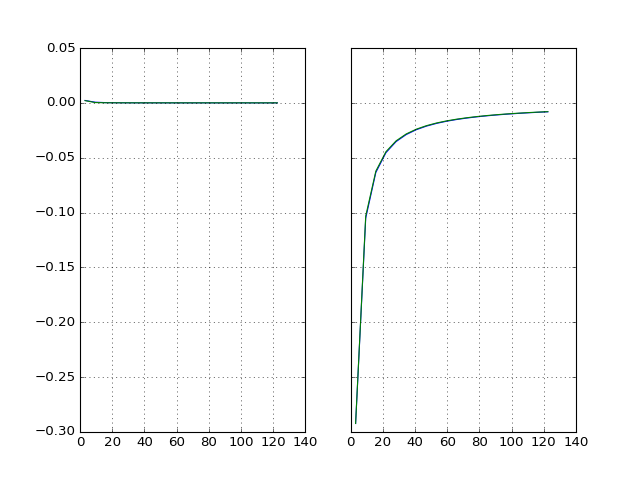

<IPython.core.display.Javascript object>


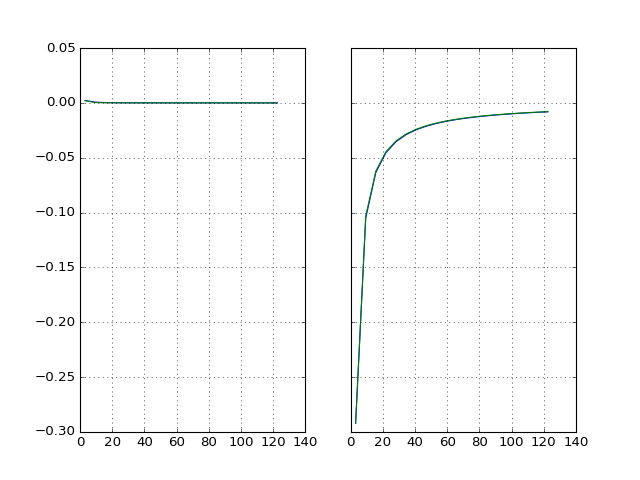

In [150]:
for i in xrange(Nc):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    ax1.plot(matsubara[:20],molecular_GF(parameters[i])[:20].real)
    ax1.plot(matsubara[:20],G0_M[:,i,i][:20].real)
    ax1.grid()
    
    ax2.plot(matsubara[:20],molecular_GF(parameters[i])[:20].imag)
    ax2.plot(matsubara[:20],G0_M[:,i,i][:20].imag)
    ax2.grid()